In [1]:
# 谷歌训练出的1000个分类是imagenet比赛上选出的1000个分类

In [2]:
# https://www.jianshu.com/p/cc830a6ed54b
# 这里我有问题：# 用谁填充了predictions[0]位置的概率？还有[1001][1002][1003][1004][1005][1006][1007]这些位置的值？ 得出的概率是跟谁比的？
# 估计要去人家的网络里看了。。。先存疑吧

In [1]:
import tensorflow as tf
import os                      # operating system 不用关心用户的操作系统了
import numpy as np             # 科学计算包
import re                      # 正则包
from PIL import  Image
import matplotlib.pyplot as plt

G:\Anaconda3\Anaconda3-5.2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
G:\Anaconda3\Anaconda3-5.2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
G:\Anaconda3\Anaconda3-5.2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
G:\Anaconda3\Anaconda3-5.2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Futu

images/airplane.jpg


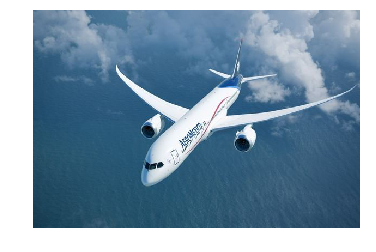

airliner (script = 0.92653)
wing (script = 0.04245)
warplane, military plane (script = 0.00439)
airship, dirigible (script = 0.00090)
ambulance (script = 0.00056)

images/car.jpg


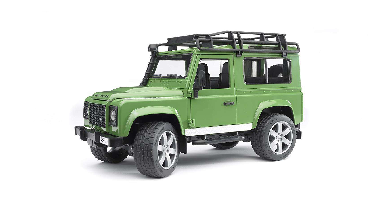

jeep, landrover (script = 0.91403)
fire engine, fire truck (script = 0.00132)
ambulance (script = 0.00092)
car wheel (script = 0.00081)
digital watch (script = 0.00079)

images/cat.jpg


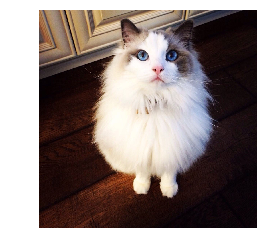

Persian cat (script = 0.68840)
Angora, Angora rabbit (script = 0.14617)
tabby, tabby cat (script = 0.01732)
lynx, catamount (script = 0.01342)
doormat, welcome mat (script = 0.00736)

images/dog.jpg


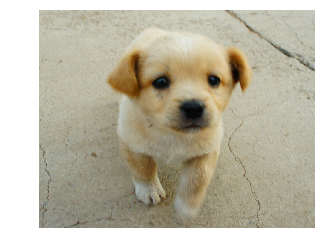

golden retriever (script = 0.81152)
Labrador retriever (script = 0.09067)
tennis ball (script = 0.00463)
Pekinese, Pekingese, Peke (script = 0.00458)
Pembroke, Pembroke Welsh corgi (script = 0.00296)

images/fish.jpg


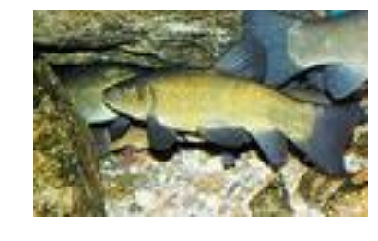

tench, Tinca tinca (script = 0.91940)
rock beauty, Holocanthus tricolor (script = 0.00317)
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus (script = 0.00197)
book jacket, dust cover, dust jacket, dust wrapper (script = 0.00129)
isopod (script = 0.00105)

images/fishs.jpg


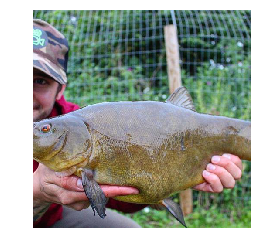

tench, Tinca tinca (script = 0.97401)
squirrel monkey, Saimiri sciureus (script = 0.00031)
barracouta, snoek (script = 0.00027)
spider monkey, Ateles geoffroyi (script = 0.00027)
reel (script = 0.00024)

images/panda.jpg


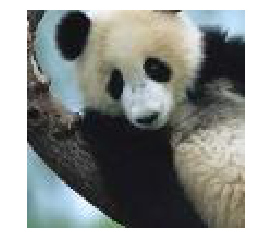

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (script = 0.89632)
indri, indris, Indri indri, Indri brevicaudatus (script = 0.00766)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (script = 0.00266)
custard apple (script = 0.00138)
earthstar (script = 0.00104)

images/狐狸.jpg


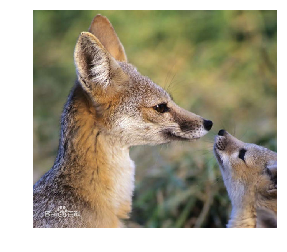

kit fox, Vulpes macrotis (script = 0.86766)
red fox, Vulpes vulpes (script = 0.05658)
grey fox, gray fox, Urocyon cinereoargenteus (script = 0.04811)
coyote, prairie wolf, brush wolf, Canis latrans (script = 0.00130)
dhole, Cuon alpinus (script = 0.00047)



In [4]:
# 先创建一个类NodeLookup来将softmax概率值映射到标签上。
class NodeLookup(object):
    def __init__(self):                                                                             # 实例化对象时初始化的魔法方法p20 p27
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'            # 模型 目标分类1-1000  编号-字符串
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'                         # 类别文件 字符串-对分类的描述
        self.node_lookup = self.load(label_lookup_path,uid_lookup_path)     # 直接调用load方法 返回给self.node_lookup
        
    def load(self, label_lookup_path, uid_lookup_path):              
        # 读文件 读 编号-字符串 的文件   这里是用tf的方法读 用np pandas python最基本的方法均可
        # 长这样 target_class: 449
        #        target_class_string: "n01440764"
        # 得字典 node_id_to_uid{449:n01440764}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            # 如果我们读到的是这样的行 分割 取[1] 即分类编号1-1000
            if line.startswith('  target_class:'): 
                target_class = int(line.split(': ')[1])
            # 如果我们得到这样的行  分割 取[1] 即编号字符串n********
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                # 保存分类编号与编号字符串映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]                                                # 取1到倒数第二个
        
        
        # 读文件 读 字符串-对分类的描述 的文件
        # 长这样 n01455778  \tab  pipefish, needlefish
        # 得字典 uid_to_human{n01455778:pipefish, needlefish}
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        # 一行一行读数据
        for line in proto_as_ascii_lines:
            # 去掉换行符 因为换行符对我们的判断没什么作用
            line = line.strip('\n')
            # 按照'\tab'分割  长这样 n01455778  \tab  pipefish, needlefish
            parsed_items = line.split('\t')
            # 获取分类编号 tab前是分类编号
            uid = parsed_items[0]
            # 获取分类名称  tab后是分类名称  
            human_string = parsed_items[1]
            # 保存编号字符串n*******与分类名称映射关系
            uid_to_human[uid] = human_string
        
# 字典 node_id_to_uid{449:n01440764}
# 字典 uid_to_human{n01440764:tench, Tinca tinca}


        # 建立分类编号对应分类名称的映射关系
# 得字典node_id_to_name[449] = Tinca tinca
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():                                                       # 以列表返回可遍历的(键,值)元组数组
            # 获取分类名称
            name = uid_to_human[val]
            # 建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
            
        return node_id_to_name

    # 传入分类编号返回分类名称
    def id_to_string(self,node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
        
        
# 创建一个图来存放Google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,name = '')

            
with tf.Session() as sess:
    # 拿到softmax的op
    # 'softmax:0'这个名字，可以在网络中找到这个节点，它的名字就'(softmax)' 可以看到 inception-v3的最后一层就是softmax
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')   # 返回给定名称的tensor （获取一个name=softmax那个操作的输出）
    
    # 遍历存放images的文件目录 得到三个参数
    # root是images本身、dirs是其目录、files是root的文件名
    for root,dirs,files in os.walk('images/'):
        # 遍历图片
        for file in files:   
            # 读入图片 路径是root下的file
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            
            # 输入图像数据，得到softmax概率值（shape=(1,1008)的向量） 把图片放入会话中计算 定义了传入图片的格式：DecodeJpeg
            # 运行softmax节点，向其中feed值
            # 可以在网络中找到这个名字，DecodeJpeg/contents，
            # 据此可以发现，根据名字取网络中op时，如果其名字带括号，就用括号内的名字，如果不带括号，就用右上角介绍的名字。
            # 而带个0，是默认情况，如果网络中出现同名节点，这个编号会递增
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})       # 图片格式是jpg
            #(1,1007)->(1007,)  横向量[[]]转列向量[]
            predictions = np.squeeze(predictions) # 把结果转化为1维数组
           
            # 打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            
            # 显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            # 排序 取出前5个概率最大的值（top-5) 这儿要倒数前五个[-5:] 然后逆序[::-1]
            # argsort()函数返回的是数组值从小到大的索引值。
            # x = array([6,3,9,2,7])>>> argsort(x) array([3, 1, 0, 4, 2])
            top_k = predictions.argsort()[-5:][::-1]
            
            # 类的实例化
            node_lookup = NodeLookup()
            
            # 把取到的从大到小的五个概率值的索引值遍历
            for node_id in top_k:
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取该分类的置信度
                score = predictions[node_id]
                print('%s (script = %.5f)' % (human_string, score))
            print()
            

In [5]:
dir(str)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',
 'zfill']

In [6]:
predictions  # 概率    # 用谁填充了0位置的概率？

array([2.2736909e-05, 8.6765641e-01, 7.2495641e-06, ..., 2.2736887e-05,
       2.2736975e-05, 2.2736975e-05], dtype=float32)

In [7]:
predictions[1]     # 0-1007 都可以 有1008个数  这里为什么不会出现不在1-1000里的数？ 它是位置值啊？

0.8676564

In [8]:
predictions.argsort() # 概率对应的从小到大的索引值 就是 预测小概率出现的位置-->大概率出现的位置

array([175, 564, 138, ...,  67,  62,   1], dtype=int64)

In [9]:
predictions.argsort()[-5:] # 取后五个 也就是大概率排名前五的索引值

array([136,  58,  67,  62,   1], dtype=int64)

In [10]:
predictions.argsort()[-5:][::-1]  # 从大到小排列

array([  1,  62,  67,  58, 136], dtype=int64)

In [11]:
top_k # 同上 可以看出这个索引值就是1-1000的

array([  1,  62,  67,  58, 136], dtype=int64)

In [12]:
node_id=predictions.argsort()[-5:][::-1][0]

In [13]:
predictions.argsort()[-5:][::-1][0]

1

In [14]:
lookup = NodeLookup()
string = lookup.id_to_string(node_id)

In [15]:
print('%s' % string)

kit fox, Vulpes macrotis


In [16]:
q=predictions.argsort()

In [17]:
q

array([175, 564, 138, ...,  67,  62,   1], dtype=int64)

In [18]:
q[1007]

1

In [19]:
t = predictions.argsort()

In [20]:
max(t)

1007

In [21]:
min(t)

0

In [22]:
human_string = node_lookup.id_to_string(0)
human_string

''

In [23]:
human_string = node_lookup.id_to_string(1)
human_string

'kit fox, Vulpes macrotis'

In [24]:
human_string = node_lookup.id_to_string(1000)
human_string

'dumbbell'

In [25]:
human_string = node_lookup.id_to_string(1001)
human_string

''

In [26]:
human_string = node_lookup.id_to_string(1007)
human_string

''

In [27]:
human_string = node_lookup.id_to_string(1008)
human_string

''